# Experiment 1: Problem as Multiclass classification
Use `Cross-entropy loss` for classification
Evaluate metrics by checking if `predicted index == monkeypox` index (5)

Imports

In [1]:
import torch
from torchvision.models import resnet50
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

import numpy as np
import random
import os
from tqdm.notebook import tqdm
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt
import json

Definitions

In [2]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)

In [3]:
classes = ['acne', 'chickenpox', 'cowpox', 'measles', 'melanoma', 'monkeypox', 'normal', 'other', 'smallpox']

In [4]:
def get_precision_recall_f1_accuracy(preds, actual):
    tp = torch.logical_and(preds, actual).sum().item()
    tn = torch.logical_and(torch.logical_not(preds), torch.logical_not(actual)).sum().item()
    fp = torch.logical_and(preds, torch.logical_not(actual)).sum().item()
    fn = torch.logical_and(torch.logical_not(preds), actual).sum().item()
    
    precision = tp / (tp + fp + 0.00001)
    recall = tp / (tp + fn + 0.00001)
    f1 = 2 * precision * recall / (precision + recall + 0.00001)
    accuracy = (tp + tn)/ (tp + tn + fp + fn + 0.00001)
    
    return precision, recall, f1, accuracy

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Dataset and Dataloader

In [5]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, indices, transform=None):
        self.idx_to_class = classes
        self.class_to_idx = {disease: idx for idx, disease in enumerate(self.idx_to_class)}
        self.image_paths = glob(os.path.join(root_dir, "*", "*"))
        self.indices = indices
        self.transform = transform
        
    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, index):
        idx = self.indices[index]
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        disease = os.path.basename(os.path.dirname(image_path))
        
        return self.transform(image), torch.tensor(self.class_to_idx[disease])

In [6]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.Resize((224, 224)),
    transforms.RandomRotation(15)
])
val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    transforms.Resize((224, 224)),
])

In [7]:
size = len(glob(os.path.join('data/combined', "*", "*")))
train_size = int(size * 0.8)
indices = list(range(size))
random.shuffle(indices)
train_set = CustomDataset('data/combined', indices[:train_size], train_transform)
val_set = CustomDataset('data/combined', indices[train_size:], val_transform)

In [8]:
train_loader = DataLoader(train_set, 8, shuffle=True)
val_loader = DataLoader(val_set, 8, shuffle=False)

Training

In [10]:
model = resnet50()
model_path = "/home/dilith/Projects/monkeypox/models/model_multi_33.pt" # "/home/dilith/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth"
# model.load_state_dict(torch.load(model_path))
model.fc = torch.nn.Linear(2048, len(classes))
model.load_state_dict(torch.load(model_path))
model = model.to(device)

In [12]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

In [11]:
mp_idx = train_set.class_to_idx["monkeypox"]
with open("/home/dilith/Projects/monkeypox/metrics_multi.json", 'r') as fp:
    metrics = json.load(fp)

In [38]:
mp_idx = train_set.class_to_idx["monkeypox"]
metrics = {phase: {metric: [] for metric in ['loss', 'acc', 'prec', 'rec', 'f1']} for phase in ['train', 'val']}

In [ ]:
best_loss = 1
cur_epoch = len(metrics['train']['loss'])
for ep in range(cur_epoch, cur_epoch + 40):
    print(f"------ Epoch {ep} ------")
    ep_metrics = {phase: {metric: 0 for metric in ['loss', 'acc', 'prec', 'rec', 'f1']} for phase in ['train', 'val']}
    for image, label in tqdm(train_loader):
        image = image.to(device)
        label = label.to(device)
        
        out = model(image)
        loss = criterion(out, label)
        
        bsz = image.size(0)
        ep_metrics['train']['loss'] += loss.item() * bsz
        prec, rec, f1, acc = get_precision_recall_f1_accuracy(out.argmax(dim=1) == mp_idx, label == mp_idx)
        ep_metrics['train']['prec'] += prec * bsz
        ep_metrics['train']['rec'] += rec * bsz
        ep_metrics['train']['f1'] += f1 * bsz
        ep_metrics['train']['acc'] += acc * bsz
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    with torch.no_grad():
        for image, label in tqdm(val_loader):
            image = image.to(device)
            label = label.to(device)
            
            out = model(image)
            loss = criterion(out, label)
            
            bsz = image.size(0)
            ep_metrics['val']['loss'] += loss.item() * bsz
            prec, rec, f1, acc = get_precision_recall_f1_accuracy(out.argmax(dim=1) == mp_idx, label == mp_idx)
            ep_metrics['val']['prec'] += prec * bsz
            ep_metrics['val']['rec'] += rec * bsz
            ep_metrics['val']['f1'] += f1 * bsz
            ep_metrics['val']['acc'] += acc * bsz
            
    
    for phase in ep_metrics:
        for metric in ep_metrics[phase]:
            ep_metrics[phase][metric] /= len(train_set if phase == 'train' else val_set)
            metrics[phase][metric].append(ep_metrics[phase][metric])
    
    if ep_metrics['val']['loss'] < best_loss:
        best_loss = ep_metrics['val']['loss']
        torch.save(model.state_dict(), f'models/model_multi_{ep}.pt')
        print("Saved Model")
    
    for phase in ep_metrics:
        print("=>", phase)
        print(ep_metrics[phase])

In [25]:
torch.save(model.state_dict(), f'models/model_multi_last.pt')

## Metrics

In [16]:
import json
with open("metrics_multi.json", "w") as fp:
    json.dump(metrics, fp)

loss


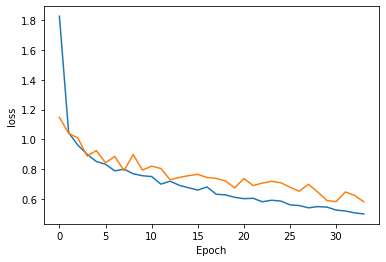

acc


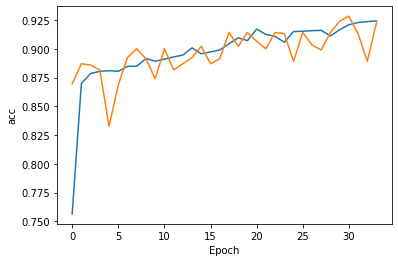

prec


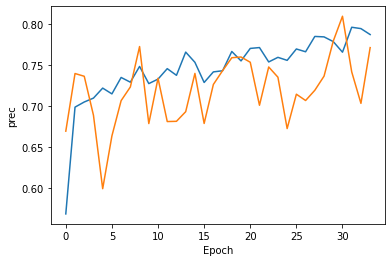

rec


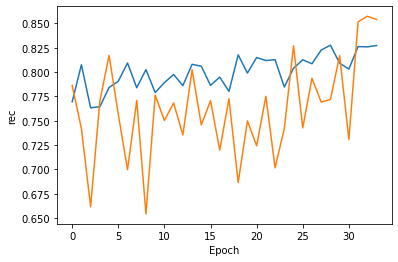

f1


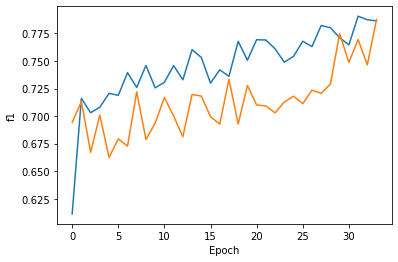

In [12]:
for metric in metrics["train"]:
    print(metric)
    for phase in metrics:
        plt.plot(range(len(metrics[phase][metric])), metrics[phase][metric])
    plt.xlabel("Epoch")
    plt.ylabel(metric)
    plt.show()

Confusion Matrix

In [21]:
conf_mat = [[0] * len(classes) for _ in classes]
y_pred, y_true = [], []
for image, label in val_set:
    image = image.to(device)
    pred = model(image.unsqueeze(dim=0)).squeeze()
    conf_mat[pred.argmax()][label.item()] += 1
    y_pred.append(pred.argmax().item())
    y_true.append(label.item())

<AxesSubplot:>

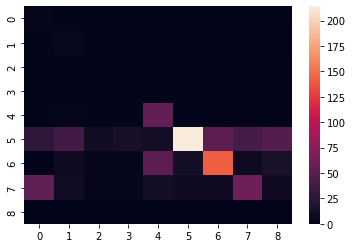

In [32]:
import seaborn as sns
sns.heatmap(conf_mat)

In [23]:
conf_mat_bin = [[0, 0], [0, 0]]
y_pred_bin, y_true_bin = [], []
for image, label in val_set:
    image = image.to(device)
    pred = model(image.unsqueeze(dim=0)).squeeze()
    conf_mat_bin[1 if (pred.argmax() == 5) else 0][1 if (label.item() == 5) else 0] += 1
    y_pred_bin.append(1 if (pred.argmax() == 5) else 0)
    y_true_bin.append(1 if (label.item() == 5) else 0)

<AxesSubplot:>

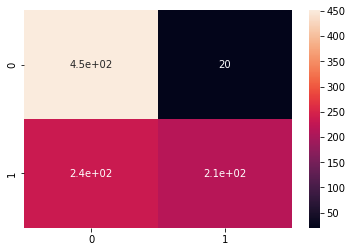

In [25]:
import seaborn as sns
sns.heatmap(conf_mat_bin, annot=True)

Classification report

In [28]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=classes, zero_division=0))

              precision    recall  f1-score   support

        acne       1.00      0.03      0.05        80
  chickenpox       0.80      0.06      0.12        62
      cowpox       0.00      0.00      0.00        14
     measles       0.00      0.00      0.00        20
    melanoma       0.95      0.42      0.58       128
   monkeypox       0.48      0.91      0.63       234
      normal       0.59      0.70      0.64       202
       other       0.37      0.56      0.45       108
    smallpox       1.00      0.01      0.03        72

    accuracy                           0.52       920
   macro avg       0.58      0.30      0.28       920
weighted avg       0.65      0.52      0.45       920



In [30]:
from sklearn.metrics import classification_report

print(classification_report(y_true_bin, y_pred_bin, zero_division=0))

              precision    recall  f1-score   support

           0       0.96      0.66      0.78       686
           1       0.48      0.91      0.63       234

    accuracy                           0.72       920
   macro avg       0.72      0.79      0.70       920
weighted avg       0.84      0.72      0.74       920

